# EPIC-pn analysis of monitoring results

Using the results of the regular monitoring on calibration lines from Michael Smith scripts.

**Note:** for the boresights CCD#4 only taking the results for `RAWY` in [181:200], which is the last line in the results file.


In [80]:
import os
import glob
import csv
import pickle

%matplotlib inline
import matplotlib.pylab as plt

import pandas as pd
import numpy as np
#import altair as alt

from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline

from datetime import date

In [84]:
today = date.today()
stoday = today.strftime("%d%m%y")

Select the line and the PN mode

In [148]:
#sline = "Al-Ka"
#sline = "Mn-Ka"
sline = "Cu-Ka"
#
# lab energies for the lines, in eV
#
line0 = {'Al-Ka': 1486.0, 'Mn-Ka': 5898.0, 'Cu-Ka': 8040.0}
#
#select_mode = "PrimeFullWindow"
select_mode = "PrimeFullWindowExtended"
xmode = {"PrimeFullWindow": "ff", "PrimeFullWindowExtended": "eff"}

Define the folders and build the list of `OBS_ID`s.

In [149]:
# folder with the monitoring results
ddir = '/xdata/xcaldata/XMM/PN/CTI/dat_RLM'
# build a list of all subfolders:
obsids = [f for f in os.listdir(ddir) if os.path.isdir(os.path.join(ddir, f))]
df1 = pd.DataFrame(data={'obsid':obsids})
nobsid = len(obsids)
print (f"Found {nobsid} folders with monitoring results.")

Found 1336 folders with monitoring results.


In [150]:
wdir = os.path.expanduser('~') + f'/IVAN/CTI/monitoring/{sline}-line'
if (not os.path.isdir(wdir)):
    print (f"Folder {wdir} does not exist. Creating it.")
    os.mkdir(wdir)
#

In [151]:
list_file = f'{wdir}/../monitoring_obsids_list.csv'
df = pd.read_csv(list_file)
# convert the obsid to strng
df['obsid'] = [f"{x:010}" for x in df['obsid']]

In [152]:
df_x = df.merge(df1,on='obsid',how='left',indicator=True)
check = (df_x['_merge'] != 'both')
inew = np.where(check)[0]
nnew = len(inew)
print (f"Found {nnew} missing OBS_ID in the summary file.")
hasNew = False
if (nnew > 0):
    new_obsids = obsids[inew]
    hasNew = True

Found 0 missing OBS_ID in the summary file.


## Merging all summary files in a table

Each sub-folder of `ddir` contains a summary file with information about the observation. I combine all this info in a table and save it for easy access to the relevant `OBS_ID`.

In [153]:
#output_file = f'{wdir}/ff_obsids_list.csv'
#fout = open(output_file,'w')
#print ("rev,obsid,expo,omode,filter,start,end,duration",file=fout)
if (hasNew):
    list_file = f'{wdir}/../monitoring_obsids_list.csv'
    # append
    fout = open(list_file,'a')
    for i,iobs in enumerate(new_obsids):
        #
        sumfile = glob.glob(f"{ddir}/{iobs}/{iobs}*smry.txt")
        # first extract useful info for the OBS_ID from the summary file
        if (len(sumfile) == 0):
            print (f"No summary file for OBS_ID {iobs}. Skipping it.")
            continue
        if (i % 100 == 0):
            print (f"Saving summary for {iobs} ({i+1}/{nobsid})")
        with open(sumfile[0], 'r') as sfile:
            csvreader = csv.reader(sfile)
            for row in csvreader:
                if row[0] in (None, ""):
                    continue
                else:
                    summary = row[0].replace("'","").split()
            #
        print (summary[0:8],file=fout)
    #
    fout.close()
#

Now loop over all folders/obsids and get the Cu K$\alpha$ results. Skip files with zero length. Will check the boresight CCD 4 first

In [154]:
df_sel = df.loc[df['omode'] == select_mode]
print (f"Found {len(df_sel)} monitoring results for mode {select_mode}\n",df_sel[0:10])

Found 140 monitoring results for mode PrimeFullWindowExtended
      rev       obsid  expo                    omode     filter  \
4    461  0012660201  S003  PrimeFullWindowExtended  CalClosed   
15   615  0073740301  S003  PrimeFullWindowExtended  CalClosed   
29   613  0065820501  S003  PrimeFullWindowExtended  CalClosed   
43   101  0098010101  S010  PrimeFullWindowExtended  CalClosed   
49   130  0109060401  S004  PrimeFullWindowExtended  CalClosed   
62   319  0093670601  S005  PrimeFullWindowExtended  CalClosed   
80   354  0049340701  S005  PrimeFullWindowExtended  CalClosed   
99   360  0082340201  S005  PrimeFullWindowExtended  CalClosed   
104  278  0112610201  S003  PrimeFullWindowExtended  CalClosed   
105  585  0141400501  S005  PrimeFullWindowExtended  CalClosed   

                   start                  end  duration  
4    2002-06-15T08:40:40  2002-06-15T08:48:51     492.2  
15   2003-04-18T13:03:56  2003-04-18T13:37:57    2042.3  
29   2003-04-14T13:20:33  2003-04-14

In [155]:
result = {}
for j in np.arange(1,13):
    result[j] = {f'{sline}': [], f'{sline}_err1': [], f'{sline}_err2': [], 'revol': [], 
                        'chi2': [], 'dof': [], 'chi2r': []}
#
for iobs,irev in zip(df_sel.obsid,df_sel.rev):
    for iccd in np.arange(1,13):
        xsearch = f"{ddir}/{iobs}/{iobs}*lmonCCD{iccd:02}_{sline}.txt"
        xfile = glob.glob(xsearch)
        if (len(xfile) > 0):
            with open(xfile[0], 'r') as datfile:
                csvreader = csv.reader(datfile)
                for row in csvreader:
                    if row[0] in (None, ""):
                        continue
                    else:
                        results = row[0].split()
            # check the flags
            if (int(results[21])*int(results[22])*int(results[23]) != 0):
                continue
            if (int(results[20]) not in [0,-15,-19]):
                continue
            #
            if (sline != 'Cu-Ka'):
                # For CCD4, the boresight, we check if RAWY is in 181:200
                if ((iccd == 4) and (int(results[2]) != 181)):
                    continue
            #
            result[iccd][f'{sline}'].append(float(results[4]))
            result[iccd][f'{sline}_err1'].append(float(results[5]))
            result[iccd][f'{sline}_err2'].append(float(results[6]))
            result[iccd]['chi2'].append(float(results[24]))
            result[iccd]['dof'].append(int(results[25]))
            if (int(results[25]) > 0):
                result[iccd]['chi2r'].append(float(results[24])/int(results[25]))
            else:
                result[iccd]['chi2r'].append(-9.0)
            result[iccd]['revol'].append(int(irev))
        #break
#
for j in np.arange(1,13):
    print (f"Found {len(result[j][f'{sline}'])} OBS_IDs with {sline} line results for mode {select_mode} for CCDNR == {j}")
#

Found 67 OBS_IDs with Cu-Ka line results for mode PrimeFullWindowExtended for CCDNR == 1
Found 86 OBS_IDs with Cu-Ka line results for mode PrimeFullWindowExtended for CCDNR == 2
Found 84 OBS_IDs with Cu-Ka line results for mode PrimeFullWindowExtended for CCDNR == 3
Found 70 OBS_IDs with Cu-Ka line results for mode PrimeFullWindowExtended for CCDNR == 4
Found 89 OBS_IDs with Cu-Ka line results for mode PrimeFullWindowExtended for CCDNR == 5
Found 87 OBS_IDs with Cu-Ka line results for mode PrimeFullWindowExtended for CCDNR == 6
Found 66 OBS_IDs with Cu-Ka line results for mode PrimeFullWindowExtended for CCDNR == 7
Found 81 OBS_IDs with Cu-Ka line results for mode PrimeFullWindowExtended for CCDNR == 8
Found 82 OBS_IDs with Cu-Ka line results for mode PrimeFullWindowExtended for CCDNR == 9
Found 65 OBS_IDs with Cu-Ka line results for mode PrimeFullWindowExtended for CCDNR == 10
Found 84 OBS_IDs with Cu-Ka line results for mode PrimeFullWindowExtended for CCDNR == 11
Found 83 OBS_IDs wi

In [156]:
resfile = f'{wdir}/{xmode[select_mode]}_{sline}_fit_results.pickle'
with open(resfile, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(result, f, pickle.HIGHEST_PROTOCOL)

In [157]:
resfile = f'{wdir}/{xmode[select_mode]}_{sline}_fit_results.pickle'
with open(resfile, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    result = pickle.load(f)

Selected 44/67 good fit results for CCD 1
Selected 64/86 good fit results for CCD 2
Selected 59/84 good fit results for CCD 3
Selected 48/70 good fit results for CCD 4
Selected 60/89 good fit results for CCD 5
Selected 61/87 good fit results for CCD 6
Selected 41/66 good fit results for CCD 7
Selected 50/81 good fit results for CCD 8
Selected 56/82 good fit results for CCD 9
Selected 43/65 good fit results for CCD 10
Selected 52/84 good fit results for CCD 11
Selected 55/83 good fit results for CCD 12


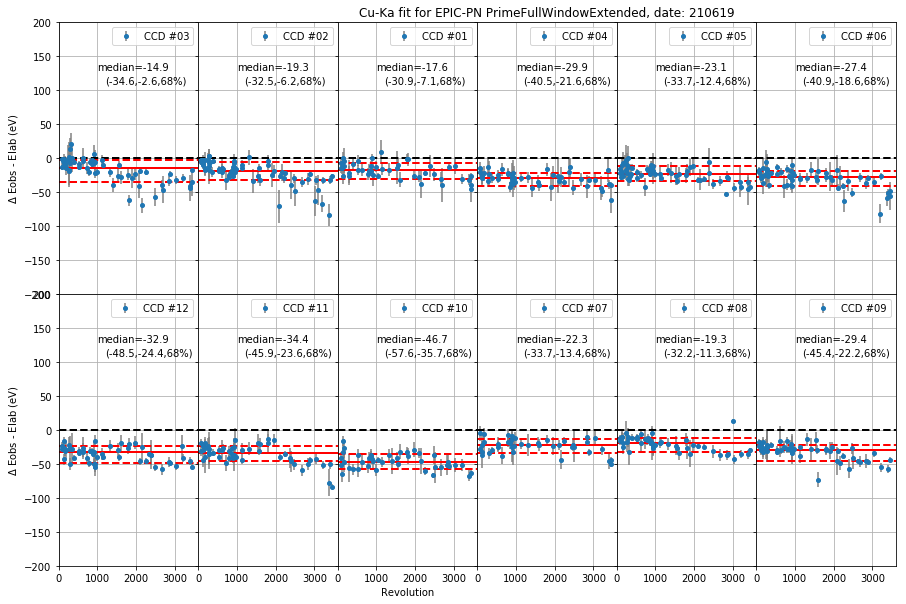

In [158]:

fig, axs = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
#
chi2r_lim = 1.3
#
mapping = {1: [0,2], 2: [0,1], 3: [0,0], 4: [0,3], 5: [0,4], 6: [0,5],
          7: [1,3], 8: [1,4], 9: [1,5], 10: [1,2], 11: [1,1], 12: [1,0]}
#
runrev = np.arange(0.0,3500.0,200.0)
#
for j in np.arange(12):
    ccd = j + 1
    #
    #
    # filter only those with good fit, i.e. chi2r above chi2r_lim
    #
    #ix = np.where(np.asarray(result[ccd]['chi2r']) <= chi2r_lim)[0]
    # 
    uncert = (np.asarray(result[ccd][f'{sline}_err2']) - np.asarray(result[ccd][f'{sline}_err1']))*5
    ix = np.where((uncert <= 50.0) & (uncert > 0.0))[0]
    print (f"Selected {len(ix)}/{len(result[ccd]['chi2r'])} good fit results for CCD {ccd}")
    #
    xrev = np.asarray(result[ccd]['revol'])[ix]
    xcu = np.asarray(result[ccd][f'{sline}'])[ix]*5.0 # in eV
    xcu_e1 = np.asarray(result[ccd][f'{sline}_err1'])[ix]*5.0 # in eV
    xcu_e2 = np.asarray(result[ccd][f'{sline}_err2'])[ix]*5.0 # in eV
    diff = xcu - line0[sline] # in eV
    diff_err1 = xcu - xcu_e1
    diff_err2 = xcu_e2 - xcu
    diff_err = (diff_err1 + diff_err2)/2.0
    #
    # for the spline we need unique x and strictly increasing
    #qrev, inx = np.unique(xrev, return_index=True)
    #qdif = diff[inx]
    #qdiferr = diff_err[inx]
    #isort = qrev.argsort()
    #
    # smooth curve with univariate weighted spline
    #wxx = 1.0/np.power(qdiferr,2)
    #s = UnivariateSpline(qrev[isort], qdif[isort], w=wxx[isort], k=4,s=2)
    #z = np.polyfit(qrev[isort], qdif[isort], 1)
    #p = np.poly1d(z)
    #qresult = p(runrev)
    #qresult = s(runrev)
    #
    # get the median
    #
    med = np.quantile(diff,0.5)
    mplus = np.quantile(diff,0.84)
    mminus = np.quantile(diff,0.16)
    axs[mapping[ccd][0],mapping[ccd][1]].errorbar(xrev,diff,yerr=(diff_err1,diff_err2),fmt='o',
                                                  ms=4,ecolor='grey',label=f'CCD #{ccd:02}')
    #axs[mapping[ccd][0],mapping[ccd][1]].plot(runrev,qresult,color='red')
    axs[mapping[ccd][0],mapping[ccd][1]].axhline(med,color='red',lw=2)
    axs[mapping[ccd][0],mapping[ccd][1]].axhline(mplus,color='red',ls='dashed',lw=2)
    axs[mapping[ccd][0],mapping[ccd][1]].axhline(mminus,color='red',ls='dashed',lw=2)
    #axs[kj,k].plot(xrev,diff,'ok',label='')
    axs[mapping[ccd][0],mapping[ccd][1]].axhline(0.0,color='black',ls='dashed',lw=2)
    axs[mapping[ccd][0],mapping[ccd][1]].text(1000,130,f"median={med:.1f}")
    axs[mapping[ccd][0],mapping[ccd][1]].text(1200,110,f"({mminus:.1f},{mplus:.1f},68%)")
    #
    axs[mapping[ccd][0],mapping[ccd][1]].set_xlim((0,3600))
    axs[mapping[ccd][0],mapping[ccd][1]].set_ylim((-200.0,200.0))
    axs[mapping[ccd][0],mapping[ccd][1]].grid(True)
    axs[mapping[ccd][0],mapping[ccd][1]].legend(loc=1)
    if (ccd == 4):
        axs[mapping[ccd][0],mapping[ccd][1]].set_title(f"{sline} fit for EPIC-PN {select_mode}, date: {stoday}")
    if (ccd == 3 or ccd == 12):
        axs[mapping[ccd][0],mapping[ccd][1]].set_ylabel(r"$\Delta$ Eobs - Elab (eV)")
    if (ccd == 10):
        axs[mapping[ccd][0],mapping[ccd][1]].set_xlabel("Revolution")
#
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(f"{wdir}/{xmode[select_mode]}_{sline}_monitoring_results_{stoday}.png",dpi=100)
#plt.savefig(f"{wdir}/../cuka_results_all_cti49_test51_plot.png",dpi=100)
#plt.savefig(f"{wdir}/../cuka_results_allccd_myproc_plot.png",dpi=100)
plt.show();
plt.close();